In [1]:
#!pip install tqdm
#!pip install progress
#!pip install sklearn

In [2]:
import tensorflow as tf
import sys
import math
import os
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from getvector import getvector
from tensorflow.python.platform import gfile
from progress.bar import Bar

## Carga del conjunto de datos

En esta sección se cargan las mamografías según su clase.

In [3]:
data_inputs = []
data_labels = []

# Checking if the 2048-dimensional vector representations of the training images are already available
if os.path.isfile('./data_inputs.txt') and os.path.isfile('./data_labels.txt'):
	data_inputs = np.loadtxt('data_inputs.txt')
	data_labels = np.loadtxt('data_labels.txt')

else: 
	# add in your images here if you want to train the model on your own images
	image_dir = './train'
	file_list = []
	file_glob = os.path.join(image_dir, '*.jpg');
	file_list.extend(gfile.Glob(file_glob))

	# I only used 300 images from the cats and dogs dataset
	file_list = file_list[0:300]
	bar = Bar('Inception-V3 is processing images:', max=300)
	for file_name in file_list:
		data_inputs.append(getvector(file_name))
		if 'cat' in file_name:
			data_labels.append([1, 0])
		else:
			data_labels.append([0, 1])
		bar.next()
	bar.finish()

	np.savetxt('data_inputs.txt', data_inputs)
	np.savetxt('data_labels.txt', data_labels)

## En esta sección se realiza la aumentación de datos

Por definir si lo haremos...

## Se configuran los parámetros iniciales

In [4]:
# Splitting into train, val, and test
train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(data_inputs, data_labels, test_size=0.3, random_state=42)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(valtest_inputs, valtest_labels, test_size=0.4, random_state=43)

In [5]:
# Setting hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 20
log_batch_step = 50

In [6]:
# useful info
n_features = np.size(train_inputs, 1)
n_labels = np.size(train_labels, 1)

In [7]:
# Placeholders for input features and labels
inputs = tf.placeholder(tf.float32, (None, n_features))
labels = tf.placeholder(tf.float32, (None, n_labels))

In [8]:
# Setting up weights and bias
weights = tf.Variable(tf.truncated_normal((n_features, n_labels), stddev=0.1), name='weights')
bias = tf.Variable(tf.zeros(n_labels), name='bias')
tf.add_to_collection('vars', weights)
tf.add_to_collection('vars', bias)

In [9]:
# Setting up operation in fully connected layer
logits = tf.add(tf.matmul(inputs, weights), bias)
prediction = tf.nn.softmax(logits)
tf.add_to_collection('pred', prediction)

In [10]:
# Defining loss of network
difference = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_sum(difference)

In [11]:
# Setting optimiser
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [12]:
# Define accuracy
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

saver = tf.train.Saver((weights, bias))

## Carga del modelo Inception

Aquí se debe realizar el transfer learning
(congelar las últimas capas del modelo y entrenar)

In [13]:
# Run tensorflow session
history = {'val_acc':[], 'val_loss':[]}
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Running the training in batches 
    batch_count = int(math.ceil(len(train_inputs)/batch_size))

    for epoch_i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_inputs = train_inputs[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            # Run optimizer
            _ = sess.run(optimizer, feed_dict={inputs: batch_inputs, labels: batch_labels})

        # Check accuracy against validation data
        val_accuracy, val_loss = sess.run([accuracy, loss], feed_dict={inputs: val_inputs, labels: val_labels})
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("After epoch {}, Loss: {}, Accuracy: {}".format(epoch_i+1, val_loss, val_accuracy))

    g = tf.get_default_graph()
    saver.save(sess, './testsave')
    

Epoch 20/20: 100%|██████████| 4/4 [00:00<00:00, 557.14batches/s]


After epoch 1, Loss: 92.86713409423828, Accuracy: 0.3518518805503845
After epoch 2, Loss: 3.6138288974761963, Accuracy: 0.9814814925193787
After epoch 3, Loss: 14.097066879272461, Accuracy: 0.9074074625968933
After epoch 4, Loss: 3.423006772994995, Accuracy: 0.9814814925193787
After epoch 5, Loss: 0.6080526113510132, Accuracy: 1.0
After epoch 6, Loss: 5.0629754066467285, Accuracy: 0.9629629850387573
After epoch 7, Loss: 4.006303310394287, Accuracy: 0.9629629850387573
After epoch 8, Loss: 0.8683314323425293, Accuracy: 1.0
After epoch 9, Loss: 0.23407116532325745, Accuracy: 1.0
After epoch 10, Loss: 0.180728942155838, Accuracy: 1.0
After epoch 11, Loss: 0.23942923545837402, Accuracy: 1.0
After epoch 12, Loss: 0.40536150336265564, Accuracy: 1.0
After epoch 13, Loss: 0.578412652015686, Accuracy: 1.0
After epoch 14, Loss: 0.6642691493034363, Accuracy: 1.0
After epoch 15, Loss: 0.6436957120895386, Accuracy: 1.0
After epoch 16, Loss: 0.5583269000053406, Accuracy: 1.0
After epoch 17, Loss: 0.4

## Métricas

{'val_acc': [0.35185188, 0.98148149, 0.90740746, 0.98148149, 1.0, 0.96296299, 0.96296299, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [92.867134, 3.6138289, 14.097067, 3.4230068, 0.60805261, 5.0629754, 4.0063033, 0.86833143, 0.23407117, 0.18072894, 0.23942924, 0.4053615, 0.57841265, 0.66426915, 0.64369571, 0.5583269, 0.45803496, 0.37140477, 0.30679563, 0.26262626]}


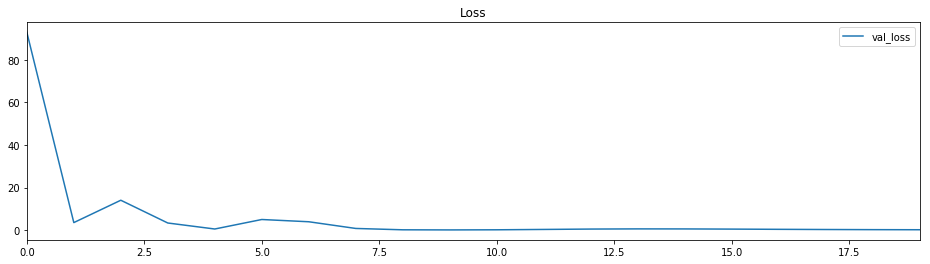

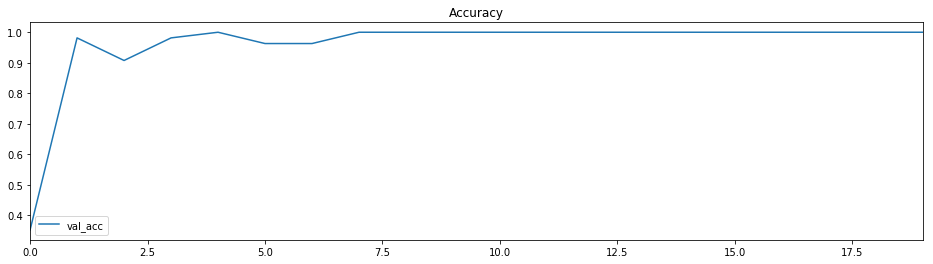

In [14]:
print(history)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(history)
#display(df)

df.plot(y=['val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['val_acc'], figsize=(16,4), title='Accuracy');

## Pruebas unitarias

In [15]:
def predict(prediction, file_name = 'cat.jpg'):
    #try: 
    #    file_name = 'cat.jpg'
    #except IndexError:
    #    print ('please enter image file path.........')
    #    exit()
    image_input = getvector(file_name).reshape((1,2048))
    if 'cat' in file_name:
        image_label = [[1, 0]]
    else:
        image_label = [[0, 1]]

    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('testsave.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        pred = sess.run(prediction, feed_dict={inputs: image_input})

        return pred

INFO:tensorflow:Restoring parameters from /home/grupoavatar/inf659-inception/transfer_learning/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: cat.jpg



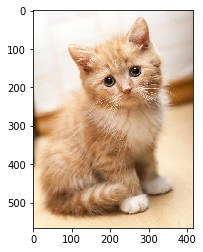

It's a cat: 0.9999996423721313, It's a dog: 3.3442003655181907e-07




INFO:tensorflow:Restoring parameters from /home/grupoavatar/inf659-inception/transfer_learning/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: dog.jpg



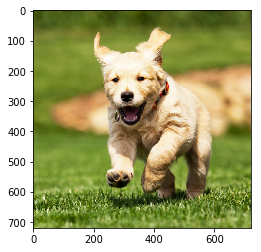

It's a cat: 8.780091775406618e-06, It's a dog: 0.9999911785125732


In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred = predict(prediction, 'cat.jpg')
print('Predict: cat.jpg\n', )
img=mpimg.imread('cat.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))
print('\n\n\n')

pred = predict(prediction, 'dog.jpg')
print('Predict: dog.jpg\n', )
img=mpimg.imread('dog.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))